## Импорты и данные 

In [1]:
import pandas as pd
import polars as pl
import numpy as np
np.random.seed(2025)
import typing as t
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
import warnings
warnings.simplefilter("ignore")

from tqdm.notebook import tqdm
from IPython.display import HTML
from dataclasses import dataclass
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize


data_folder = "/home/gleb_galagan/tbank_recsys/sirius_recsys/sirius-2025-recsys/data/"
train = pl.read_parquet(data_folder + "train.pq")
books = pl.read_parquet('/home/gleb_galagan/tbank_recsys/baseline_solution/books_all_embs.parquet')
test_exploded = pl.read_parquet(data_folder + "test.pq")
test = test_exploded.group_by("user_id", maintain_order=True).agg(pl.col("item_id"))

In [2]:
n_books = books.shape[0]
print(f"N books: {n_books}")

n_cold_books = n_books - train["item_id"].n_unique()
print(f"N 'cold' books: {n_cold_books}")

all_books = set(books['item_id']) 
train_books = set(train['item_id'])
cold_books = all_books - train_books
hot_books = all_books & train_books


N books: 34322
N 'cold' books: 3022


**NOTE** здесь я убрал evaluate_recommender чтобы не занимать место, в предыдущем ноутбуке было видно что класс я не менял

In [3]:
# ACHTUNG! DO NOT TOUCH

@dataclass
class AtKMetric(ABC):
    k: int

    @property
    @abstractmethod
    def name(self) -> str:
        raise NotImplementedError

    @property
    def full_name(self) -> str:
        return f"{self.name}@{self.k}"

    @abstractmethod
    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth", **kwargs) -> pl.Expr:
        raise NotImplementedError


class NDCG(AtKMetric):
    @property
    def name(self) -> str:
        return "ndcg"

    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth", **kwargs) -> pl.Expr:
        def _dcg(scores: np.ndarray) -> float:
            # Handle empty arrays
            if len(scores) == 0:
                return 0.0
            # Use vectorized operations for better performance
            positions = np.arange(1, len(scores) + 1, dtype=np.float64)
            return np.sum((np.power(2, scores) - 1) / np.log2(positions + 1))

        def ndcg(predicted: list[t.Any], gt_items: list[t.Any]) -> float:
            # Handle empty predictions or ground truth
            if not predicted or not gt_items:
                return 0.0
                
            # Take only top-k predictions
            predicted = predicted[:self.k]
            
            # Create relevance scores (1 for relevant items, 0 otherwise)
            relevance = np.array([1 if x in gt_items else 0 for x in predicted], dtype=np.float64)
            
            rank_dcg = _dcg(relevance)
            if rank_dcg == 0.0:
                return 0.0
                
            # Ideal DCG: sort ground truth by relevance (all 1s) and take top-k
            ideal_relevance = np.ones(min(len(gt_items), self.k), dtype=np.float64)
            ideal_dcg = _dcg(ideal_relevance)
            
            if ideal_dcg == 0.0:
                return 0.0
                
            return rank_dcg / ideal_dcg

        return pl.struct([preds_col, ground_truth_col]).map_elements(
            lambda x: ndcg(x[preds_col], x[ground_truth_col]),
            return_dtype=pl.Float64
        ).alias(self.full_name)


class Recall(AtKMetric):
    @property
    def name(self) -> str:
        return "recall"

    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth", **kwargs) -> pl.Expr:
        def recall(predicted: list[t.Any], gt_items: list[t.Any]) -> float:
            # Handle empty ground truth
            if not gt_items:
                return 0.0
                
            # Take only top-k predictions
            predicted = predicted[:self.k]
            
            # Calculate intersection
            intersection = len(set(gt_items).intersection(set(predicted)))
            return intersection / len(gt_items)

        return pl.struct([preds_col, ground_truth_col]).map_elements(
            lambda x: recall(x[preds_col], x[ground_truth_col]),
            return_dtype=pl.Float64
        ).alias(self.full_name)

# ==================
# Новая метрика ARP
# ==================
class ARP(AtKMetric):
    """
    Calculates the Average Recommendation Popularity (ARP).
    This metric measures the average popularity of the recommended items.
    A lower ARP suggests the model is recommending less obvious, "long-tail" items.
    """
    @property
    def name(self) -> str:
        return "arp"

    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth", item_popularity_map: dict[t.Any, float] | None = None, **kwargs) -> pl.Expr:
        if item_popularity_map is None:
            raise ValueError("item_popularity_map is required for ARP metric")

        def arp(predicted: list[t.Any]) -> float:
            if isinstance(predicted, pl.Series):
                predicted = predicted.to_list()
            if not predicted:
                return 0.0
            
            predicted = predicted[:self.k]
            
            # Get popularities, default to 0 if item not in map
            popularities = [item_popularity_map.get(item, 0.0) for item in predicted]
            
            if not popularities:
                return 0.0
                
            return sum(popularities) / len(popularities)

        # Note: ground_truth_col is not used but is part of the abstract method signature.
        return pl.col(preds_col).map_elements(
            lambda p: arp(p),
            return_dtype=pl.Float64
        ).alias(self.full_name)
        
# ==============
# Новая метрика Serndipity
# ==============
class Serendipity(AtKMetric):
    """
    Calculates Serendipity.
    This metric rewards recommendations that are both relevant (in ground truth)
    and surprising (unpopular). The score for a user is the sum of (1 - popularity)
    for each correctly recommended item.
    """
    @property
    def name(self) -> str:
        return "serendipity"

    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth", item_popularity_map: dict[t.Any, float] | None = None, **kwargs) -> pl.Expr:
        if item_popularity_map is None:
            raise ValueError("item_popularity_map is required for Serendipity metric")

        def serendipity(predicted: list[t.Any], gt_items: list[t.Any]) -> float:
            if not predicted or not gt_items:
                return 0.0
                
            predicted = predicted[:self.k]
            
            # Find relevant recommended items
            relevant_preds = set(predicted).intersection(set(gt_items))
            
            if not relevant_preds:
                return 0.0
                
            # Score is the sum of (1 - popularity) for each relevant item
            score = sum(1 - item_popularity_map.get(item, 0.0) for item in relevant_preds)
            
            # Normalize by k to get an average serendipity score per recommendation slot
            return score / self.k

        return pl.struct([preds_col, ground_truth_col]).map_elements(
            lambda x: serendipity(x[preds_col], x[ground_truth_col]),
            return_dtype=pl.Float64
        ).alias(self.full_name)



def coverage(df: pl.DataFrame, n_items_in_catalog: int, preds_col: str = "preds") -> float:
    if n_items_in_catalog <= 0:
        return 0.0
        
    unique_recommended = df.select(
        pl.col(preds_col).explode().n_unique()
    ).item()
    return unique_recommended / n_items_in_catalog



def evaluate_extended(
    df: pl.DataFrame,
    model_preds_col: str,
    ground_truth_col: str = "item_id",
    n_items_in_catalog: int = n_books,
    k: int = 10,
    train_df: pl.DataFrame | None = train,
) -> dict:
    """
    Расширенная функция расчета метрик. Здесь добавлены ARP и Serendipity. Для расчета этих метрик считаем матрицу популярности. 
    """
    # Compute item_popularity_map from train_df
    if train_df is not None:
        total_interactions = train_df.height
        item_counts = (
            train_df
            .group_by("item_id")
            .agg(pl.count().alias("count"))
        )
    
    # Normalize by maximum count to get 0-1 range
        max_count = item_counts.select(pl.col("count").max()).item()
    
        item_popularity_map = dict(
            item_counts
            .with_columns((pl.col("count") / max_count).alias("popularity"))
            .select(["item_id", "popularity"])
            .iter_rows()
        )
    else:
        item_popularity_map = None

    metrics = [
        NDCG(k=k),
        Recall(k=k),
    ]

    if item_popularity_map:
        metrics.extend([
            ARP(k=k),
            Serendipity(k=k),
        ])

    result = {}
    result_df = df.clone()

    for metric in metrics:
        metric_kwargs = {
            "preds_col": model_preds_col,
            "ground_truth_col": ground_truth_col,
        }
        if isinstance(metric, (ARP, Serendipity)):
            if not item_popularity_map:
                print(f"Skipping {metric.name} because item_popularity_map is not provided.")
                continue
            metric_kwargs["item_popularity_map"] = item_popularity_map

        # Calculate metric
        result_df = result_df.with_columns(
            metric(**metric_kwargs)
        )
        
        result[metric.full_name] = round(result_df.select(pl.col(metric.full_name).mean()).item(), 3)

    if n_items_in_catalog is not None:
        result["coverage"] = round(coverage(result_df, n_items_in_catalog, preds_col=model_preds_col), 3)

    return result


In [4]:
def evaluate_cold_item_performance(
    df: pl.DataFrame,
    model_preds_col: str,
    ground_truth_col: str = "item_id",
    cold_items: set[int] = train,
    k: int = 10,
) -> dict:
    """
    Evaluates model performance specifically on cold vs warm items.
    For each user, splits their ground truth into cold/warm and measures
    how many cold items vs warm items the model successfully recommends.
    """
    
    def split_ground_truth_and_calculate_metrics(predicted: list, gt_items: list) -> dict:
        if not predicted or not gt_items:
            return {"cold_hits": 0, "warm_hits": 0, "total_cold_gt": 0, "total_warm_gt": 0}
        
        predicted_top_k = predicted[:k]
        predicted_set = set(predicted_top_k)
        
        # Split ground truth into cold and warm
        cold_gt = [item for item in gt_items if item in cold_items]
        warm_gt = [item for item in gt_items if item not in cold_items]
        
        # Count hits for each type
        cold_hits = len([item for item in cold_gt if item in predicted_set])
        warm_hits = len([item for item in warm_gt if item in predicted_set])
        
        return {
            "cold_hits": cold_hits,
            "warm_hits": warm_hits,
            "total_cold_gt": len(cold_gt),
            "total_warm_gt": len(warm_gt)
        }
    
    # Apply the function to each row
    results = []
    for row in df.iter_rows(named=True):
        predicted = row[model_preds_col]
        gt_items = row[ground_truth_col]
        results.append(split_ground_truth_and_calculate_metrics(predicted, gt_items))
    
    # Aggregate results
    total_cold_hits = sum(r["cold_hits"] for r in results)
    total_warm_hits = sum(r["warm_hits"] for r in results)
    total_cold_gt = sum(r["total_cold_gt"] for r in results)
    total_warm_gt = sum(r["total_warm_gt"] for r in results)
    
    metrics = {}
    
    # Cold item recall
    if total_cold_gt > 0:
        metrics["cold_item_recall"] = round(total_cold_hits / total_cold_gt, 3)
    else:
        metrics["cold_item_recall"] = 0.0
    
    # Warm item recall  
    if total_warm_gt > 0:
        metrics["warm_item_recall"] = round(total_warm_hits / total_warm_gt, 3)
    else:
        metrics["warm_item_recall"] = 0.0
    
    # Additional statistics
    metrics["total_cold_items_in_gt"] = total_cold_gt
    metrics["total_warm_items_in_gt"] = total_warm_gt
    metrics["cold_items_recommended"] = total_cold_hits
    metrics["warm_items_recommended"] = total_warm_hits
    
    return metrics


def evaluate_by_user_types(
    df: pl.DataFrame,
    model_preds_col: str,
    ground_truth_col: str = "item_id",
    cold_items: set[int] = cold_books,
    k: int = 10,
    train_df: pl.DataFrame | None = train,
) -> dict:
    """
    Evaluates performance by user types:
    - pure_cold: users who have ONLY cold items in ground truth
    - mixed: users who have both cold and warm items
    - pure_warm: users who have ONLY warm items in ground truth
    """
    
    # Classify users
    df = df.with_columns([
        # Count cold items in ground truth
        pl.col(ground_truth_col)
        .list.eval(pl.element().is_in(cold_items))
        .list.sum()
        .alias("cold_count"),
        
        # Total items in ground truth
        pl.col(ground_truth_col).list.len().alias("total_count")
    ]).with_columns([
        # Classify user types
        pl.when(pl.col("cold_count") == pl.col("total_count"))
        .then(pl.lit("pure_cold"))
        .when(pl.col("cold_count") == 0)
        .then(pl.lit("pure_warm"))  
        .otherwise(pl.lit("mixed"))
        .alias("user_type")
    ])
    
    metrics = [NDCG(k=k), Recall(k=k)]
    result = {}
    
    # Add popularity-based metrics if train_df is available
    if train_df is not None:
        item_counts = train_df.group_by("item_id").agg(pl.count().alias("count"))
        max_count = item_counts.select(pl.col("count").max()).item()
        item_popularity_map = dict(
            item_counts
            .with_columns((pl.col("count") / max_count).alias("popularity"))
            .select(["item_id", "popularity"])
            .iter_rows()
        )
        metrics.extend([ARP(k=k), Serendipity(k=k)])
    else:
        item_popularity_map = None
    
    # Evaluate each user type
    for user_type in ["pure_cold", "mixed", "pure_warm"]:
        type_df = df.filter(pl.col("user_type") == user_type)
        
        if type_df.height == 0:
            continue
            
        print(f"\n{user_type}: {type_df.height} users")
        
        for metric in metrics:
            metric_kwargs = {
                "preds_col": model_preds_col,
                "ground_truth_col": ground_truth_col,
            }
            
            if isinstance(metric, (ARP, Serendipity)) and item_popularity_map:
                metric_kwargs["item_popularity_map"] = item_popularity_map
            
            type_df = type_df.with_columns(metric(**metric_kwargs))
            result[f"{metric.full_name}_{user_type}"] = round(
                type_df.select(pl.col(metric.full_name).mean()).item(), 3
            )
    
    return result

## 0 ItemKNN cosine
Здесь используем новый эмбеддинг description_embedding который должен лучше всего характеризовать книгу, лучше чем теги и изображения и меняем метрику на косинус

In [5]:
import warnings
import pandas as pd
import numpy as np
import polars as pl
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity  # Add this import

class ItemkNNCosine:
    def __init__(self):
        self.trained: bool = False
        self.train_most_liked_item: pl.DataFrame | None = None
        self.items_embeddings: np.ndarray | None = None
        self.items_item_ids: np.ndarray | None = None

    def fit(
        self,
        df: pl.DataFrame,
        items_df: pl.DataFrame,
        item_id_col: str = "item_id"
    ) -> None:
        self.items_embeddings = np.array(items_df["description_embeddings"].to_list())
        self.items_item_ids = items_df[item_id_col].to_numpy()

        # Find the most liked item for each user
        self.train_most_liked_item = (
            df.lazy()
            .sort("rating", descending=True)
            .group_by("user_id")
            .agg(pl.col(item_id_col).first().alias(item_id_col))
            .join(
                items_df.lazy().select([item_id_col, "description_embeddings"]),
                on=item_id_col,
                how="left"
            )
            .collect()
        )
        self.trained = True

    def _get_batch_predictions(
        self,
        batch_user_embeddings: np.ndarray,
        batch_current_items: np.ndarray,
        batch_user_mask: np.ndarray,
        topn: int
    ) -> list[np.ndarray]:
        batch_predictions = []
        
        # Compute cosine similarity scores for all items in batch
        batch_scores = cosine_similarity(batch_user_embeddings, self.items_embeddings)

        for user_scores, current_item, has_embedding in zip(
            batch_scores, batch_current_items, batch_user_mask
        ):
            if not has_embedding:
                batch_predictions.append([])
                continue

            # Get top (topn + 1) most similar items
            top_indices = np.argpartition(-user_scores, topn + 1)[:topn + 1]
            
            # Filter out current item and take topn
            recommended_items = []
            for item_idx in top_indices:
                if self.items_item_ids[item_idx] != current_item:
                    recommended_items.append(self.items_item_ids[item_idx])
                if len(recommended_items) >= topn:
                    break

            batch_predictions.append(recommended_items)

        return batch_predictions

    def predict(
        self,
        df: pl.DataFrame,
        topn: int = 10,
        batch_size: int = 5_000
    ) -> list[np.ndarray]:
        assert self.trained
        
        user_data = (
            df.select(["user_id"])
            .join(self.train_most_liked_item, on="user_id", how="left")
        )

        user_embeddings = np.array(user_data["description_embeddings"].to_list())
        current_items = user_data["item_id"].to_numpy()
        user_mask = user_data["description_embeddings"].is_not_null().to_numpy()

        predictions = []
        n_users = len(user_data)

        for batch_start in tqdm(range(0, n_users, batch_size)):
            batch_end = min(batch_start + batch_size, n_users)
            
            batch_predictions = self._get_batch_predictions(
                user_embeddings[batch_start:batch_end],
                current_items[batch_start:batch_end],
                user_mask[batch_start:batch_end],
                topn
            )
            predictions.extend(batch_predictions)

        return predictions

item_knn_cosine = ItemkNNCosine()
item_knn_cosine.fit(train, books)
test = test.with_columns(
    item_knn_cosine_recs=pl.Series(item_knn_cosine.predict(test))
)
print(test.head())


cosine_rec_overall = evaluate_extended(
        df=test,
        model_preds_col="item_knn_cosine_recs",
        n_items_in_catalog=n_books,
        k=10,
        train_df=train  # Must have "item_id" column
    )

cosine_rec_split = evaluate_by_user_types(df=test,
        model_preds_col="item_knn_cosine_recs",
        cold_items=cold_books,
        
        k=10,)

cosine_rec_perf = evaluate_cold_item_performance(df=test,
        model_preds_col="item_knn_cosine_recs",
    )
knn_results_ov = {}
knn_results_split = {}
knn_results_perf = {}
knn_results_split['item_knn_cosine_recs'] = cosine_rec_split
knn_results_ov['item_knn_cosine_recs'] = cosine_rec_overall
knn_results_perf['item_knn_cosine_recs'] = cosine_rec_perf
cosine_rec_overall

100%|██████████| 38/38 [01:42<00:00,  2.70s/it]


shape: (5, 3)
┌─────────────────────────────────┬───────────────────────┬─────────────────────────┐
│ user_id                         ┆ item_id               ┆ item_knn_cosine_recs    │
│ ---                             ┆ ---                   ┆ ---                     │
│ str                             ┆ list[i64]             ┆ list[i64]               │
╞═════════════════════════════════╪═══════════════════════╪═════════════════════════╡
│ 00000377eea48021d3002730d56aca… ┆ [13252]               ┆ [22632, 11374, … 17767] │
│ 00009ab2ed8cbfceda5a59da409663… ┆ [2328]                ┆ [14708, 20984, … 3563]  │
│ 00009e46d18f223a82b22da38586b6… ┆ [28636, 30197]        ┆ [7320, 18150, … 9355]   │
│ 0001085188e302fc6b2568de45a5f5… ┆ [2159, 2969, … 33630] ┆ [22632, 11374, … 17767] │
│ 00014c578111090720e20f5705eba0… ┆ [45, 3513, … 33273]   ┆ [29816, 15917, … 24549] │
└─────────────────────────────────┴───────────────────────┴─────────────────────────┘

pure_cold: 1703 users

mixed: 44793 use

{'ndcg@10': 0.01,
 'recall@10': 0.011,
 'arp@10': 0.026,
 'serendipity@10': 0.006,
 'coverage': 0.688}

## 1 Embeddings 
Здесь рассмотрим какой из эмебддингов дает наилучшее качество

In [6]:
class ItemkNN:
    def __init__(self):
        self.trained: bool = False
        self.train_most_liked_item: pl.DataFrame | None = None
        self.items_embeddings: np.ndarray | None = None
        self.items_item_ids: np.ndarray | None = None
        self.emb_col = None

    def fit(
        self,
        df: pl.DataFrame,
        items_df: pl.DataFrame,
        emb_col: str,
        item_id_col: str = "item_id"
    ) -> None:
        self.emb_col = emb_col
        self.items_embeddings = np.array(items_df[emb_col].to_list())
        self.items_item_ids = items_df[item_id_col].to_numpy()

        # find the most liked item for each user
        self.train_most_liked_item = (
            df.lazy()
            .sort("rating", descending=True)
            .group_by("user_id")
            .agg(pl.col(item_id_col).first().alias(item_id_col))
            .join(
                items_df.lazy().select([item_id_col, emb_col]),
                on=item_id_col,
                how="left"
            )
            .collect()
        )
        self.trained = True

    def _get_batch_predictions(
        self,
        batch_user_embeddings: np.ndarray,
        batch_current_items: np.ndarray,
        batch_user_mask: np.ndarray,
        topn: int
    ) -> list[np.ndarray]:
        batch_predictions = []
        
        # compute similarity scores for all items in batch
        batch_scores = batch_user_embeddings @ self.items_embeddings.T

        for user_scores, current_item, has_embedding in zip(
            batch_scores, batch_current_items, batch_user_mask
        ):
            if not has_embedding:
                batch_predictions.append([])
                continue

            # get top (topn + 1) most similar items
            top_indices = np.argpartition(-user_scores, topn + 1)[:topn + 1]
            
            # filter out current item and take topn
            recommended_items = []
            for item_idx in top_indices:
                if self.items_item_ids[item_idx] != current_item:
                    recommended_items.append(self.items_item_ids[item_idx])
                if len(recommended_items) >= topn:
                    break

            batch_predictions.append(recommended_items)

        return batch_predictions

    def predict(
        self,
        df: pl.DataFrame,
        topn: int = 10,
        batch_size: int = 5_000
    ) -> list[np.ndarray]:
        assert self.trained
        
        user_data = (
            df.select(["user_id"])
            .join(self.train_most_liked_item, on="user_id", how="left")
        )

        user_embeddings = np.array(user_data[self.emb_col].to_list())
        current_items = user_data["item_id"].to_numpy()
        user_mask = user_data[self.emb_col].is_not_null().to_numpy()

        predictions = []
        n_users = len(user_data)

        for batch_start in tqdm(range(0, n_users, batch_size)):
            batch_end = min(batch_start + batch_size, n_users)
            
            batch_predictions = self._get_batch_predictions(
                user_embeddings[batch_start:batch_end],
                current_items[batch_start:batch_end],
                user_mask[batch_start:batch_end],
                topn
            )
            predictions.extend(batch_predictions)

        return predictions




In [7]:
cols = ['title_embeddings', 'image_embedding', 'description_embeddings']
knn_results_ov = {}
knn_results_split = {}
# knn_results_split['item_knn_cosine_recs'] = cold_rec_split
# knn_results_ov['item_knn_cosine_recs'] = cold_rec_overall
# knn_results_perf['item_knn_cosine_recs'] = cold_rec_perf
for col in cols:
    item_knn = ItemkNN()
    item_knn.fit(train, books, col)
    
    # Create dynamic column name
    recs_col_name = f"item_knn_{col}"
    
    test = test.with_columns(
        pl.Series(recs_col_name, item_knn.predict(test))
    )
    # print(f"Results for {col}:")
    ext_split = evaluate_by_user_types(df=test,
        model_preds_col=recs_col_name,
        cold_items=cold_books,
        
        )

    ext_overall = evaluate_extended(
        df=test,
        model_preds_col=recs_col_name,
        n_items_in_catalog=n_books,
        k=10,
    )
    ext_perf = evaluate_cold_item_performance(
        df=test,
        model_preds_col=recs_col_name,
    )

    knn_results_split[recs_col_name] = ext_split
    knn_results_ov[recs_col_name] = ext_overall
    knn_results_perf[recs_col_name] = ext_perf

knn_results_split_pd = pd.DataFrame(knn_results_split)
knn_results_split_pd.index.name = "metric"

knn_results_ov_pd = pd.DataFrame(knn_results_ov)
knn_results_ov_pd.index.name = "metric"

knn_results_perf_pd = pd.DataFrame(knn_results_perf)
knn_results_perf_pd.index.name = "metric"



100%|██████████| 38/38 [01:39<00:00,  2.63s/it]



pure_cold: 1703 users

mixed: 44793 users

pure_warm: 139332 users


100%|██████████| 38/38 [01:37<00:00,  2.56s/it]



pure_cold: 1703 users

mixed: 44793 users

pure_warm: 139332 users


100%|██████████| 38/38 [01:36<00:00,  2.53s/it]



pure_cold: 1703 users

mixed: 44793 users

pure_warm: 139332 users


### Анализ результатов

In [8]:
import pandas as pd
import numpy as np

# Example DataFrame
np.random.seed(42)

# Function to highlight row-wise best/worst
def highlight_row(s):
    is_max = s == s.max()
    is_min = s == s.min()
    return [
        "background-color: green" if v else
        "background-color: salmon" if w else ""
        for v, w in zip(is_max, is_min)
    ]
    

styled = knn_results_split_pd.style.apply(highlight_row, axis=1)
knn_results_split_pd.to_csv('results_csv/knn_variations_split.csv')
styled


,item_knn_title_embeddings,item_knn_image_embedding,item_knn_description_embeddings
metric,,,
ndcg@10_pure_cold,0.006000,0.000000,0.010000
recall@10_pure_cold,0.013000,0.001000,0.025000
arp@10_pure_cold,0.018000,0.011000,0.018000
serendipity@10_pure_cold,0.001000,0.000000,0.003000
ndcg@10_mixed,0.012000,0.004000,0.013000
recall@10_mixed,0.004000,0.001000,0.005000
arp@10_mixed,0.024000,0.013000,0.025000
serendipity@10_mixed,0.010000,0.003000,0.011000
ndcg@10_pure_warm,0.008000,0.002000,0.009000


In [9]:
knn_results_ov_pd.to_csv('results_csv/knn_variations_ov.csv')

knn_results_ov_pd.style.apply(highlight_row, axis=1)

,item_knn_title_embeddings,item_knn_image_embedding,item_knn_description_embeddings
metric,,,
ndcg@10,0.009000,0.002000,0.010000
recall@10,0.009000,0.002000,0.011000
arp@10,0.023000,0.014000,0.026000
serendipity@10,0.006000,0.001000,0.006000
coverage,0.804000,0.240000,0.687000


In [10]:
knn_results_perf_pd.to_csv('results_csv/knn_results_perf.csv')

knn_results_perf_pd.style.apply(highlight_row, axis=1)


,item_knn_cosine_recs,item_knn_title_embeddings,item_knn_image_embedding,item_knn_description_embeddings
metric,,,,
cold_item_recall,0.000000,0.000000,0.000000,0.000000
warm_item_recall,0.004000,0.004000,0.001000,0.004000
total_cold_items_in_gt,0.000000,0.000000,0.000000,0.000000
total_warm_items_in_gt,3134593.000000,3134593.000000,3134593.000000,3134593.000000
cold_items_recommended,0.000000,0.000000,0.000000,0.000000
warm_items_recommended,13152.000000,11641.000000,3017.000000,13158.000000


- Метрики всех выбранных эмбеддингов выше эмбеддингов тегов *'ndcg@10': 0.007, 'recall@10': 0.008, 'coverage': 0.764* только coverage остался ниже. Но у эмбеддингов названий выше 

- Из выбранных эмбеддингов хуже всего ведет себя эмбеддинги изображений. В целом это логично, поскольку "не суди книгу по обложке", несмртря на то что у нас категория книг Young Adult. Логично наиболее важная фича в рекомендации книг будет описание

- Неожиданно эмбеддинги описаний хорошо работают

- Грустно что холодные айтемы совсем не рекомендуются, по всей видимости простое сравнение "в лоб" описания/тэга/названия/обложки любимой книги юзера не дает нам нужного результата. И возможно холодные айтемы не так похожи на любимую книгу юзера

## EDA рекомендаций

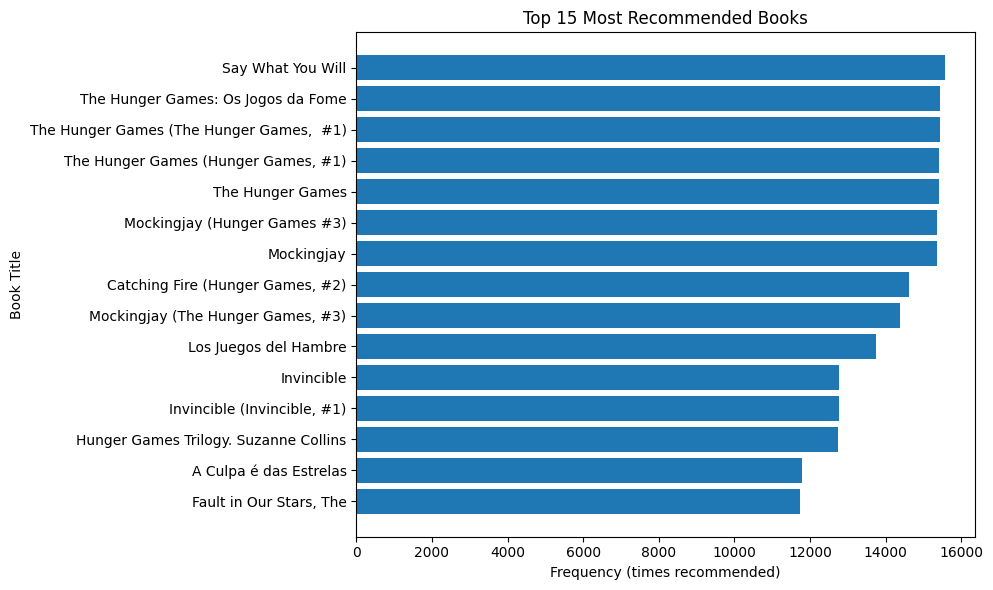

In [11]:
# 1. Flatten recommendations properly
flat_recs = test.select(pl.col("item_knn_cosine_recs").explode().alias("item_id"))

# 2. Count frequencies
freq_df = (
    flat_recs.group_by("item_id")
    .agg(pl.count().alias("count"))
    .sort("count", descending=True)
)

# 3. Join with book titles
top_10_df = (
    freq_df.head(15)
    .join(books.select(["item_id", "title"]), on="item_id", how="left")
)

# 4. Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(top_10_df["title"].to_list()[::-1], top_10_df["count"].to_list()[::-1])
plt.xlabel("Frequency (times recommended)")
plt.ylabel("Book Title")
plt.title("Top 15 Most Recommended Books")
plt.tight_layout()
plt.show()


- Также как в MAB есть 6 одинаковых по популярности тайтлов. 

- В топе есть как довольно популярные тайтлы (Голодные игры) так и например тайтлы на испанском  языке

- топ 1 15тысяч рекомендаций (при 34к уникальных юзерах), это очень большой перекос, т. е. более трети юзеров видят в своих рекомендациях тайтл Say What You Will


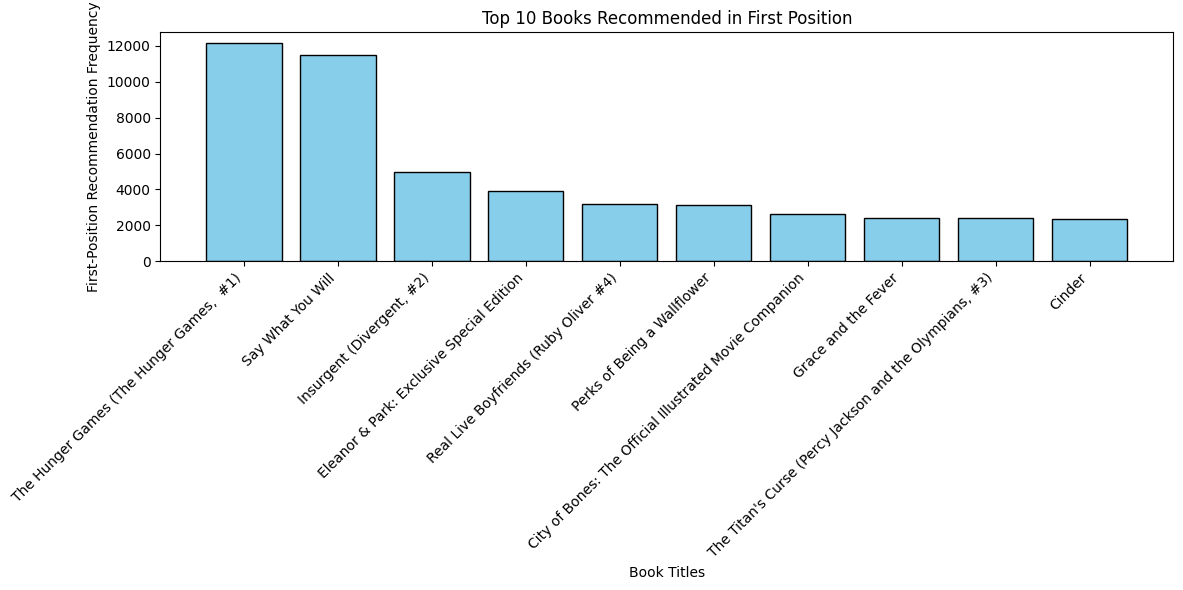

In [12]:
# Extract first-position recommendation directly in Polars
first_position_recs = test.select(
    pl.col("item_knn_cosine_recs").list.get(0).alias("item_id")
)

# Count frequency
freq_df = (
    first_position_recs.group_by("item_id")
    .agg(pl.count().alias("count"))
    .sort("count", descending=True)
)

# Join with books metadata
top_10_df = (
    freq_df.head(10)
    .join(books.select(["item_id", "title"]), on="item_id", how="left")
    .with_columns(pl.col("title").fill_null("Unknown Title"))
)

# Prepare data for plotting
titles = top_10_df["title"].to_list()
counts = top_10_df["count"].to_list()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(titles, counts, color="skyblue", edgecolor="black")
plt.xlabel("Book Titles")
plt.ylabel("First-Position Recommendation Frequency")
plt.title("Top 10 Books Recommended in First Position")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


- В топ 1 по популярности снова есть серии (причем не 1я серия, а 2, 3 и 4 серии)

- В отличие от MAB 

#### Сохраняем модель с эмбеддингами описаний


In [14]:

import joblib
item_knn_descriptions = ItemkNN()
item_knn_descriptions.fit(train, books, 'description_embeddings')


# Save
joblib.dump(item_knn_descriptions, "models/item_knn_descriptions.joblib")

# Load
loaded_model = joblib.load("models/item_knn_descriptions.joblib")

print(loaded_model.trained)


True
